<a href="https://colab.research.google.com/github/HARDIK218/Projects/blob/main/Spam_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
data = pd.read_csv('/content/spam_Bert.csv')

In [ ]:
data.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data['Category'].unique()

array(['ham', 'spam'], dtype=object)

In [ ]:
data = pd.get_dummies(data, columns=["Category"],drop_first=True)

In [ ]:
data["Category"] = data["Category_spam"].astype("int8")

In [ ]:
data = data.drop('Category_spam',axis=1)

In [ ]:
data

,Message,Category
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1
5568,Will ü b going to esplanade fr home?,0
5569,"Pity, * was in mood for that. So...any other s...",0
5570,The guy did some bitching but I acted like i'd...,0


In [ ]:
data.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
0           4825   4516                             Sorry, I'll call later   
1            747    641  Please call our customer service representativ...   

               
         freq  
Category       
0          30  
1           4

In [ ]:
data_spam = data[data['Category'] == 1]
data_spam.shape

(747, 2)

In [ ]:
data_ham = data[data['Category'] == 0]
data_ham.shape

(4825, 2)

In [ ]:
data_ham_downsampled = data_ham.sample(data_spam.shape[0])
data_ham_downsampled.shape

(747, 2)

In [ ]:
data_balanced = pd.concat([data_spam,data_ham_downsampled])
data_balanced.shape

(1494, 2)

In [ ]:
data_balanced

,Message,Category
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,FreeMsg Hey there darling it's been 3 week's n...,1
8,WINNER!! As a valued network customer you have...,1
9,Had your mobile 11 months or more? U R entitle...,1
11,"SIX chances to win CASH! From 100 to 20,000 po...",1
...,...,...
3426,True. Its easier with her here.,0
775,Just sleeping..and surfing,0
1652,I wan but too early lei... Me outside now wun ...,0
1631,I am going to film 2day da. At 6pm. Sorry da.,0


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(data_balanced['Message'],data_balanced['Category'],test_size=0.2,random_state=42)

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
#one method(not using here)
def get_sentence(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_outout']

In [ ]:
text_input = tf.keras.layers.Input(shape=(),dtype=tf.string,name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#neural network layers

l = tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1,activation='sigmoid',name = 'output')(l)

#final model
model = tf.keras.Model(inputs = [text_input],outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [ ]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name ='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=metrics)


In [ ]:
model.fit(x_train,y_train,epochs = 5)

Epoch 1/5
38/38 [==============================] - 26s 320ms/step - loss: 0.6650 - accuracy: 0.6310 - precision: 0.6331 - recall: 0.6362
Epoch 2/5
38/38 [==============================] - 12s 312ms/step - loss: 0.5305 - accuracy: 0.8042 - precision: 0.8067 - recall: 0.8040
Epoch 3/5
38/38 [==============================] - 12s 324ms/step - loss: 0.4493 - accuracy: 0.8720 - precision: 0.8674 - recall: 0.8804
Epoch 4/5
38/38 [==============================] - 13s 333ms/step - loss: 0.4007 - accuracy: 0.8870 - precision: 0.8736 - recall: 0.9070
Epoch 5/5
38/38 [==============================] - 13s 342ms/step - loss: 0.3745 - accuracy: 0.8820 - precision: 0.8641 - recall: 0.9086


In [ ]:
model.evaluate(x_test,y_test)

10/10 [==============================] - 5s 355ms/step - loss: 0.3651 - accuracy: 0.8528 - precision: 0.8741 - recall: 0.8138


[0.36506158113479614,
 0.8528428077697754,
 0.8740741014480591,
 0.8137931227684021]

In [ ]:
y_predicted = model.predict(x_test)
y_predicted = y_predicted.flatten()

10/10 [==============================] - 4s 326ms/step


In [ ]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5,1,0)
y_predicted

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1])

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_predicted)
cm

array([[137,  17],
       [ 27, 118]])

Text(50.722222222222214, 0.5, 'Truth')

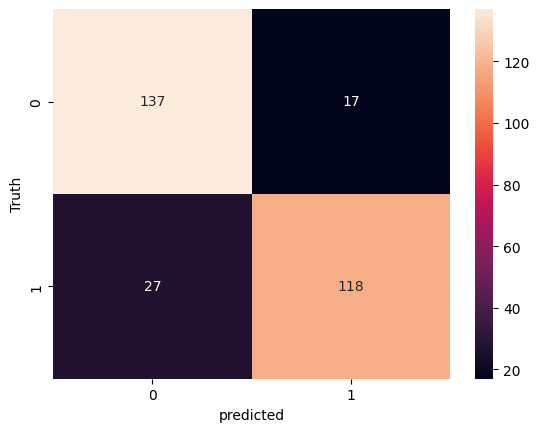

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm,annot = True,fmt = 'd')
plt.xlabel('predicted')
plt.ylabel('Truth')